In [46]:
import os 
import mne
import numpy as np
import torch
import torch.nn as nn
import torchvision
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [48]:
def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()


class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, root, s: str):
    self.root = root
    nights = ['night1']

    self.all_meg_data = []
    self.all_epochs = []
    for night in nights:
      data_path_folder = os.path.join(self.root, rf'{s}\{night}')
      wm = os.listdir(data_path_folder)[-1]
      self.data_path = os.path.join(self.root, rf'{s}\{night}\{wm}')

      raw = mne.io.read_raw_ctf(self.data_path, preload=True)
      raw.pick_types(meg=True, stim=True, eeg=True, ref_meg=True)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True)
      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 255
      sel = np.where(events[:, 2] <= 255)[0]
      events = events[sel, :]
      picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                              exclude='bads')
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                          baseline=None, preload=True)
      self.epochs.resample(120)   ### filtert es schonb?
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
      self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs)
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.all_meg_data[idx, :, :], self.all_epochs.events[idx, 2]

In [49]:

class CustomBatchNorm1d(nn.BatchNorm1d):
    def forward(self, input):
        if input.size(0) == 1:
            return input
        return super().forward(input)

class NaiveModel(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()

        self.backbone = backbone

        out_features = list(self.backbone.modules())[-1].out_features
        
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            CustomBatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            CustomBatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            CustomBatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        
        output = self.cls_head(x)
        return output

In [ ]:
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from functools import partial
from typing import Optional, Union, Callable, List, Tuple
from termcolor import cprint


class SpatialAttention(nn.Module):
    def __init__(
        self, loc: torch.Tensor, D1: int, K: int, d_drop: float, flat: bool = True
    ):
        super().__init__()

        self.flat = flat

        # TODO: Check if those two are identical.
        x, y = loc.T
        if self.flat:  # Implementation version 1
            self.z_re = nn.Parameter(torch.Tensor(D1, K, K))
            self.z_im = nn.Parameter(torch.Tensor(D1, K, K))
            nn.init.kaiming_uniform_(self.z_re, a=np.sqrt(5))
            nn.init.kaiming_uniform_(self.z_im, a=np.sqrt(5))

            k_arange = torch.arange(K)
            rad1 = torch.einsum("k,c->kc", k_arange, x)
            rad2 = torch.einsum("l,c->lc", k_arange, y)
            rad = rad1.unsqueeze(1) + rad2.unsqueeze(0)
            self.register_buffer("cos", torch.cos(2 * torch.pi * rad))
            self.register_buffer("sin", torch.sin(2 * torch.pi * rad))

        else:  # Implementation version 2
            # make a complex-valued parameter, reshape k,l into one dimension
            self.z = nn.Parameter(torch.rand(size=(D1, K**2), dtype=torch.cfloat))

            # vectorize of k's and l's
            a = []
            for k in range(K):
                for l in range(K):
                    a.append((k, l))
            a = torch.tensor(a)
            k, l = a[:, 0], a[:, 1]
            # NOTE: pre-compute the values of cos and sin (they depend on k, l, x and y which repeat)
            phi = 2 * torch.pi * (torch.einsum("k,x->kx", k, x) + torch.einsum("l,y->ly", l, y))  # fmt: skip
            self.register_buffer("cos", torch.cos(phi))
            self.register_buffer("sin", torch.sin(phi))

        self.spatial_dropout = SpatialDropout(loc, d_drop)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """_summary_

        Args:
            X ( b, c, t ): _description_

        Returns:
            _type_: _description_
        """
        # NOTE: drop some channels within a d_drop of the sampled channel
        X = self.spatial_dropout(X)  # ( b, c, t )

        if self.flat:
            real = torch.einsum("dkl,klc->dc", self.z_re, self.cos)
            imag = torch.einsum("dkl,klc->dc", self.z_im, self.sin)
            # ( D1, c )
        else:
            real = torch.einsum("jm, me -> je", self.z.real, self.cos)
            imag = torch.einsum("jm, me -> je", self.z.imag, self.sin)

        # NOTE: to get the softmax spatial attention weights over input electrodes,
        # we don't compute exp, etc (as in the eq. 5), we take softmax instead:
        a = F.softmax(real + imag, dim=-1)  # ( D1, c )

        # NOTE: each output is a diff weighted sum over each input channel
        return torch.einsum("oi,bit->bot", a, X)


class SpatialDropout(nn.Module):
    """Using same drop center for all samples in batch"""

    def __init__(self, loc, d_drop):
        super().__init__()
        self.loc = loc  # ( num_channels, 2 )
        self.d_drop = d_drop
        self.num_channels = loc.shape[0]

    def forward(self, X):  # ( B, num_channels, seq_len )
        #assert X.shape[1] == self.num_channels

        if self.training:
            drop_center = self.loc[np.random.randint(self.num_channels)]  # ( 2, )
            distances = (self.loc - drop_center).norm(dim=-1)  # ( num_channels, )
            mask = torch.where(distances < self.d_drop, 0.0, 1.0).to(device=X.device)
            # ( num_channels, )
            X = mask.view(1, -1, 1) * X
            # cprint(1 - torch.count_nonzero(X) / torch.numel(X), "yellow")

        return X


class SubjectBlock(nn.Module):
    def __init__(
        self,
        num_subjects: int,
        loc: np.ndarray,
        D1: int,
        K: int,
        d_drop: float,
        num_channels: int,
        spatial_attention: bool = True,
    ):
        super().__init__()

        self.num_subjects = num_subjects

        if spatial_attention:
            self.spatial_attention = SpatialAttention(loc, D1, K, d_drop)
        else:
            cprint("Not using spatial attention.", "yellow")
            self.spatial_attention = None

        self.conv = nn.Conv1d(
            in_channels=D1 if spatial_attention else num_channels,
            out_channels=D1,
            kernel_size=1,
            stride=1,
        )
        self.subject_layer = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=D1,
                    out_channels=D1,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                )
                for _ in range(self.num_subjects)
            ]
        )

    def forward(
        self, X: torch.Tensor, subject_idxs: Optional[torch.Tensor]
    ) -> torch.Tensor:
        if self.spatial_attention is not None:
            X = self.spatial_attention(X)  # ( B, 270, 256 )

        X = self.conv(X)  # ( B, 270, 256 )

        if subject_idxs is not None:
            X = torch.cat(
                [
                    self.subject_layer[i](x.unsqueeze(dim=0))
                    for i, x in zip(subject_idxs, X)
                ]
            )  # ( B, 270, 256 )

        else:
            cprint("Unknown subject.", "yellow")

            X = torch.stack(
                [self.subject_layer[i](X) for i in range(self.num_subjects)]
            ).mean(dim=0)

        return X


class ConvBlock(nn.Module):
    def __init__(
        self,
        k: int,
        D1: int,
        D2: int,
        ksize: int = 3,
        p_drop: float = 0.1,
    ) -> None:
        super().__init__()

        self.k = k
        in_channels = D1 if k == 0 else D2

        self.conv0 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=D2,
            kernel_size=ksize,
            padding="same",
            dilation=2 ** ((2 * self.k) % 5),
        )
        self.batchnorm0 = nn.BatchNorm1d(num_features=D2)
        self.conv1 = nn.Conv1d(
            in_channels=D2,
            out_channels=D2,
            kernel_size=ksize,
            padding="same",
            dilation=2 ** ((2 * self.k + 1) % 5),
        )
        self.batchnorm1 = nn.BatchNorm1d(num_features=D2)
        self.conv2 = nn.Conv1d(
            in_channels=D2,
            out_channels=2 * D2,
            kernel_size=ksize,
            padding="same",
            dilation=2,  # NOTE: The text doesn't say this, but the picture shows dilation=2
        )
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if self.k == 0:
            X = self.conv0(X)
        else:
            X = self.conv0(X) + X  # skip connection

        X = F.gelu(self.batchnorm0(X))

        X = self.conv1(X) + X  # skip connection
        X = F.gelu(self.batchnorm1(X))

        X = self.conv2(X)
        X = F.glu(X, dim=-2)

        return self.dropout(X)


class TemporalAggregation(nn.Module):
    def __init__(
        self,
        temporal_dim: int,
        embed_dim: int,
        temporal_agg: str = "affine",
        multiplier: int = 1,
    ) -> None:
        super().__init__()

        """Modified from: https://ai.meta.com/static-resource/image-decoding"""
        # self.layers = nn.Sequential()

        # NOTE: conv_final corresponds to linear projection in the paper as long as the kernel size and stride are 1
        # self.layers.add_module("linear_projection",nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim * expand * multiplier, kernel_size=1))

        if temporal_agg == "affine":
            self.layers = nn.Linear(temporal_dim, multiplier)
        elif temporal_agg == "pool":
            self.layers = nn.AdaptiveAvgPool1d(1)
        else:
            raise NotImplementedError()

        # NOTE: MLP projectors are provided for CLIP and MSE
        # self.layers.add_module("mlp_projector",nn.Sequential(nn.Flatten(), nn.Linear(embed_dim * expand * multiplier, embed_dim * multiplier), nn.GELU()))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)  # ( b, F * multiplier )


class BrainEncoder(nn.Module):
    def __init__(self, subjects: Union[int, List[str]]) -> None:
        super().__init__()

        D1, D2, D3, K, F = 270, 320, 1024, 32, 2
        temporal_dim = 504
        num_clip_tokens = 1
        num_subjects: int = subjects if isinstance(subjects, int) else len(subjects)
        num_channels: int = 295
        spatial_attention: bool = True
        num_blocks: int = 2
        conv_block_ksize: int = 3
        temporal_agg: str = "affine"
        p_drop: float = 0.1
        d_drop: float = 0.1
        final_ksize: int = 1
        final_stride: int = 1

        self.ignore_subjects = False

        loc = self._ch_locations_2d(r"C:\Users\gschmidt\BrainDecoding\configs\thingsmeg_montage.npy")

        num_subjects = num_subjects if not self.ignore_subjects else 1
        self.subject_block = SubjectBlock(
            num_subjects, loc, D1, K, d_drop, num_channels, spatial_attention
        )

        self.blocks = nn.Sequential()

        for k in range(num_blocks):
            self.blocks.add_module(
                f"block{k}", ConvBlock(k, D1, D2, conv_block_ksize, p_drop)
            )

        self.conv_final = nn.Conv1d(
            in_channels=D2,
            out_channels=D3,
            kernel_size=final_ksize,
            stride=final_stride,
        )

        # temporal_dim = conv_output_size(
        #     init_temporal_dim,
        #     ksize=final_ksize,
        #     stride=final_stride,
        #     repetition=3 if temporal_agg == "original" else 1,
        #     downsample=sum(downsample),
        # )

        self.temporal_aggregation = TemporalAggregation(
            temporal_dim, D3, temporal_agg, multiplier=num_clip_tokens
        )

        #self.clip_head = nn.Sequential(nn.LayerNorm([D3, num_clip_tokens]), nn.GELU(), nn.Conv1d(D3, F, 1))  # fmt: skip
        #self.mse_head = nn.Sequential(nn.LayerNorm([D3, num_clip_tokens]), nn.GELU(), nn.Conv1d(D3, F, 1))  # fmt: skip

        self.clip_head = nn.Linear(1024, 2)

    @staticmethod
    def _ch_locations_2d(montage_path: str) -> torch.Tensor:
        loc = np.load(montage_path)

        # Min-max normalization
        loc = (loc - loc.min(axis=0)) / (loc.max(axis=0) - loc.min(axis=0))

        # Scale down to keep a margin of 0.1 on each side
        loc = loc * 0.8 + 0.1

        return torch.from_numpy(loc.astype(np.float32))

    def forward(self, X: torch.Tensor, subject_idxs: torch.Tensor) -> torch.Tensor:
        X = self.subject_block(
            X, subject_idxs if not self.ignore_subjects else torch.zeros_like(subject_idxs)  # fmt: skip
        )

        X = self.blocks(X)

        X = F.gelu(self.conv_final(X))

        X = self.temporal_aggregation(X)

        X = X.squeeze(-1)

        Z_clip = self.clip_head(X)

        return Z_clip

    def encode(
        self,
        X: torch.Tensor,
        subject_idxs: Optional[torch.Tensor],
        return_mse: bool = True,
        normalize: bool = True,
        stats: Optional[Tuple[float]] = None,
        device=None,
    ) -> torch.Tensor:
        if device is not None:
            orig_device = X.device
            X, subject_idxs = X.to(device), subject_idxs.to(device)

        single = X.dim == 2

        if single:
            X = X.unsqueeze(0)

            if subject_idxs is not None:
                subject_idxs = subject_idxs.unsqueeze(0)

        Z = self(X, subject_idxs)
        Z = Z[1] if return_mse else Z[0]

        if normalize:
            Z /= Z.norm(dim=-1, keepdim=True)

        if stats is not None:
            # Inverse normalization
            Z = (Z - Z.mean()) / Z.std()
            mean, std = stats
            Z = Z * std + mean

        if device is not None:
            Z = Z.to(orig_device)

        if single:
            Z = Z.squeeze(0)

        return Z


In [51]:
dataset = meg_dataset(root = r'\\memo-15\DataE\MEGA\raw', s = 'S12')

train_idcs = np.arange(0, len(dataset))
np.random.seed(42)
np.random.shuffle(train_idcs)
train_idcs = train_idcs[:int(len(train_idcs)*0.8)]
test_idcs = np.setdiff1d(np.arange(0, len(dataset)), train_idcs)
train_idcs = torch.from_numpy(train_idcs).to(device)
test_idcs = torch.from_numpy(test_idcs).to(device)
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)


#clear_output()

ds directory : \\memo-15\DataE\MEGA\raw\S12\night1\12_Sleep_20180111_04.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -3.90   71.23    0.00 mm <->   -3.90   71.23    0.00 mm (orig :  -39.97   63.22 -289.34 mm) diff =    0.000 mm
       3.90  -71.23    0.00 mm <->    3.90  -71.23    0.00 mm (orig :   66.45  -31.48 -281.61 mm) diff =    0.000 mm
      87.08    0.00    0.00 mm <->   87.08    0.00    0.00 mm (orig :   64.20   69.69 -239.76 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    10 EEG electrode locations assigned to channel info.
    10 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for \\memo-15\DataE\MEGA\raw\S12\night1\12_Sleep_20180111_04.ds\12_Sleep_20180111_04.meg4: 
    System clock channel is available, checking which samples ar

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 120 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 278 out of 278 | elapsed:    5.0s finished
C:\Users\gschmidt\AppData\Local\Temp\ipykernel_8748\2227779263.py:42: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  self.all_epochs = mne.concatenate_epochs(self.all_epochs)


Not setting metadata
400 matching events found
No baseline correction applied


400 320 80
torch.Size([295, 504]) 43


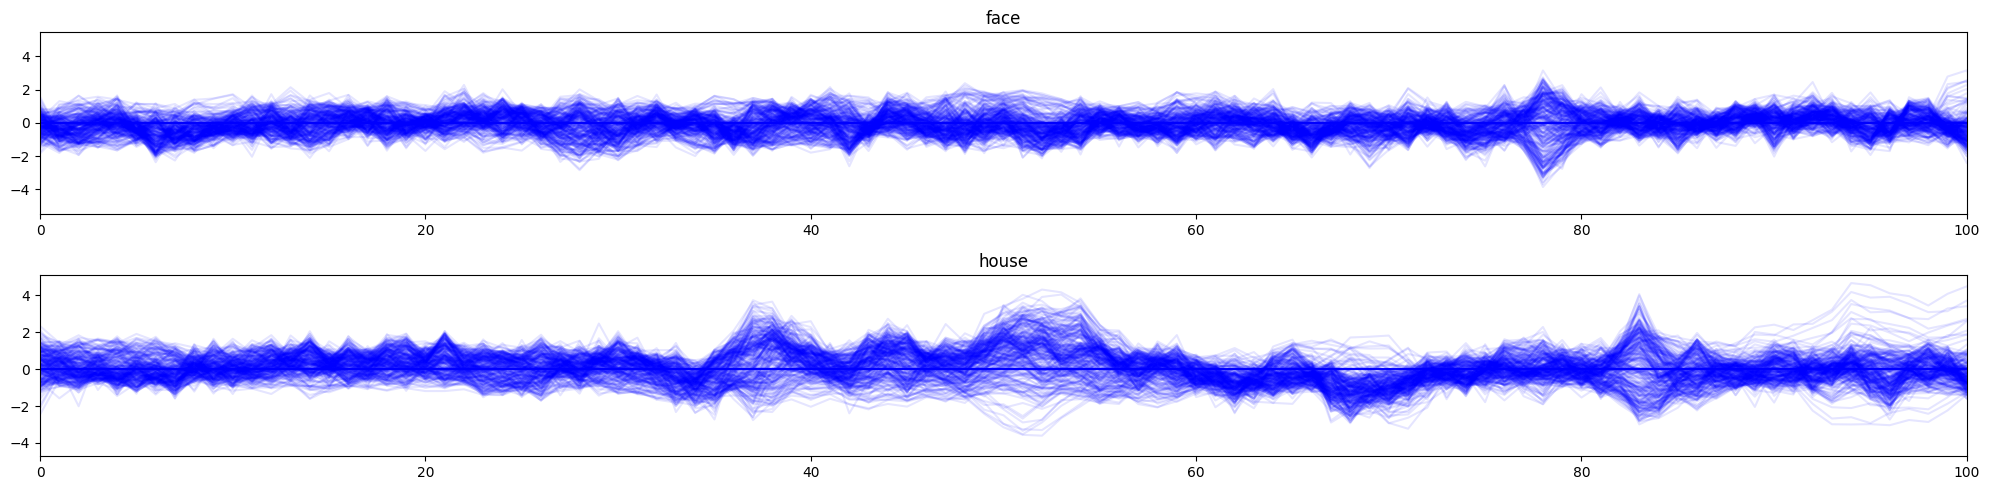

In [52]:
print(len(dataset), len(train_dataset), len(test_dataset))
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, len(dataset))
    meg, label = dataset[np.random.randint(0, len(dataset))]
    for i in range(meg.shape[0]):
        ax.plot(meg[i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'{'house' if label == 43 else 'face'}')
    ax.set_xlim(0, 100)
print(meg.shape, label)
plt.tight_layout()
plt.show()

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
model = BrainEncoder([2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc = [], []
train_loss, train_acc = [], []
for epoch in range(50):
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch', leave=False)
    lossinho = 0
    acc = 0
    for idx, (data, target) in enumerate(progress_bar):
        target = [0 if i == 43 else 1 for i in target]
        #data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data = data[:, :271, :]
        print(data.shape)
        data, target = data.to(device), torch.tensor(target).to(device)
        output = model(data, subject_idxs=np.zeros_like(target))
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum().item()
        acc += correct / total

        lossinho += loss.item()
        progress_bar.set_postfix(loss=lossinho/(idx+1))
    print(f'Epoch {epoch+1} Loss: {lossinho/len(train_loader):.4f}')
    train_loss.append(lossinho/len(train_loader))
    train_acc.append(acc/len(train_loader))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        lossinho = 0
        for data, target in test_loader:
            target = [0 if i == 43 else 1 for i in target]
            data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])

            data, target = data.to(device), torch.tensor(target).to(device)
            output = model(data, subject_idxs=np.zeros_like(target))
            loss = loss_fn(output, target)
            lossinho += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%, Loss: {lossinho/len(test_loader):.4f}')
    test_loss.append(lossinho/len(test_loader))
    test_acc.append(accuracy/len(test_loader))

Epoch 1:   0%|          | 0/5 [00:00<?, ?batch/s]

torch.Size([64, 271, 504])


torch.Size([64, 1024, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x1 and 1024x2)

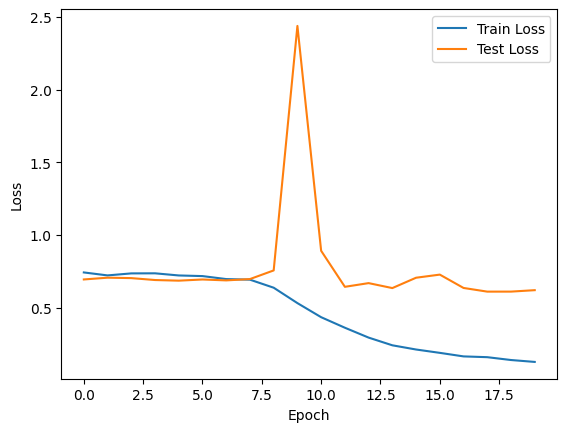

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(test_loss, label='Test Loss', color='red')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(test_acc, label='Test Accuracy', color='red')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.tight_layout()
plt.show()